PART 3 OF IMAGE COLORIZATION PROJECT

By Chetna Agarwal

In [1]:
from keras.layers import Conv2D, UpSampling2D, Input
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import tensorflow as tf
import keras
import os

In [2]:
# Replace the encoder part with VGG16. Use VGG 16 as a feature extractor and not a classifier.
# We can remove the last dense layer, adding 19 layers to our model. The dimensions of the last 
# volume are (7, 7, 512).
# Use the latent space volume as a feature vector to be input to the decoder. The decoder will
# learn the mapping from the latent space vector to the AB channel. 

In [3]:
from keras.applications.vgg16 import VGG16
vggmodel = VGG16()
newmodel = Sequential() 
for i, layer in enumerate(vggmodel.layers):
    if i<19:          #Only up to 19th layer to include feature extraction only
      newmodel.add(layer)
newmodel.summary()
for layer in newmodel.layers:
  layer.trainable=False   #We don't want to train these layers again, so False. 

553476096/553467096 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                       

In [4]:
# VGG expects an image of 3 dimensions of size (224, 224) as an input, in preprocessing
# we have to scale all the images to 224 instead of 256

In [22]:
path = '/content/drive/MyDrive/Image colorizer/Images_flowers/'
#Normalize images - divide by 255
train_datagen = ImageDataGenerator(rescale=1. / 255)
train = train_datagen.flow_from_directory(path, target_size=(224, 224), batch_size=32, class_mode=None)

Found 866 images belonging to 12 classes.


In [23]:
# convert RGB images to Lab
X =[]
Y =[]
for img in train[0]:
  try:
      lab = rgb2lab(img)
      X.append(lab[:,:,0]) 
      Y.append(lab[:,:,1:] / 128) #A and B values range from -127 to 128, 
      #so we divide the values by 128 to restrict values to between -1 and 1.
  except:
     print('error')
X = np.array(X)
Y = np.array(Y)
X = X.reshape(X.shape+(1,)) #dimensions to be the same for X and Y
print(X.shape)
print(Y.shape)

(32, 224, 224, 1)
(32, 224, 224, 2)


In [24]:
# We have one channel of L in each layer but, VGG16 is expecting 3 dimensions, 
# so we repeat the L channel two times to get 3 dimensions of the same L channel

In [25]:
vggfeatures = []
for i, sample in enumerate(X):
  sample = gray2rgb(sample)
  sample = sample.reshape((1,224,224,3))
  prediction = newmodel.predict(sample)
  prediction = prediction.reshape((7,7,512))
  vggfeatures.append(prediction)
vggfeatures = np.array(vggfeatures)
print(vggfeatures.shape)

(32, 7, 7, 512)


In [26]:
#Decoder
model = Sequential()

model.add(Conv2D(256, (3,3), activation='relu', padding='same', input_shape=(7,7,512)))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.summary()

# train using google colab GPUs
model.compile(optimizer='Adam', loss='mse' , metrics=['accuracy'])
model.fit(vggfeatures, Y, verbose=1, epochs=2000, batch_size=128)
# ran for 4000 epochs 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 7, 7, 256)         1179904   
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         295040    
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        73792     
                                                                 
 up_sampling2d_1 (UpSampling  (None, 28, 28, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)       

In [27]:
model.save('/content/drive/MyDrive/Image colorizer/Flower_models/colorize_flowers_model1_2000epochs')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Image colorizer/Flower_models/colorize_flowers_model1/assets


In [28]:
testpath = "/content/drive/MyDrive/Image colorizer/Flower_test_images/"
files = os.listdir(testpath)

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 12 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


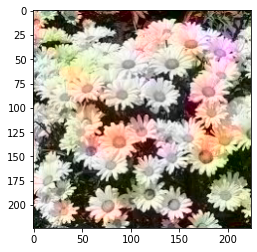

In [32]:
# import model trained for 10000 epochs and apply on test images
#model = tf.keras.models.load_model('/content/drive/MyDrive/Image colorizer/Flower_models/colorize_flowers_model1_2000epochs')
import matplotlib.pyplot as plt
test = img_to_array(load_img("/content/drive/MyDrive/Image colorizer/Flower_test_images/Daisies65.jpg"))
test = resize(test, (224, 224), anti_aliasing = True)
test *= 1.0/255
lab = rgb2lab(test)
l = lab[:,:,0]
L = gray2rgb(l)
L = L.reshape((1, 224, 224, 3))
vggpred = newmodel.predict(L)
ab = model.predict(vggpred)
ab = ab*128
cur = np.zeros((224, 224, 3))
cur[:,:,0] = l
cur[:,:,1:] = ab
plt.imshow(lab2rgb(cur))

In [33]:
def colorize(img_path):
  test = img_to_array(load_img(img_path))
  test = resize(test, (224, 224), anti_aliasing = True)
  test *= 1.0/255
  lab = rgb2lab(test)
  l = lab[:,:,0]
  L = gray2rgb(l)
  L = L.reshape((1, 224, 224, 3))
  vggpred = newmodel.predict(L)
  ab = model.predict(vggpred)
  ab = ab*128
  cur = np.zeros((224, 224, 3))
  cur[:,:,0] = l
  cur[:,:,1:] = ab
  plt.imshow(lab2rgb(cur))

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 1586 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


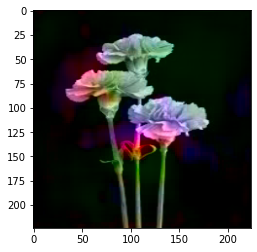

In [38]:
colorize("/content/drive/MyDrive/Image colorizer/Flower_test_images/Carnation flowers4.jpg")

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 2 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


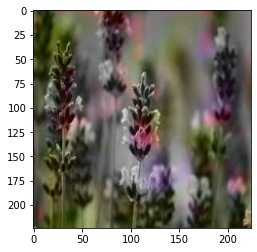

In [35]:
colorize("/content/drive/MyDrive/Image colorizer/Flower_test_images/Lavender flowers50.jpg")

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 174 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


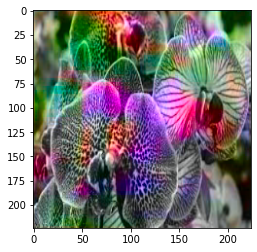

In [49]:
colorize("/content/drive/MyDrive/Image colorizer/Images_flowers/Orchids/Orchids21.jpg")

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 15 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


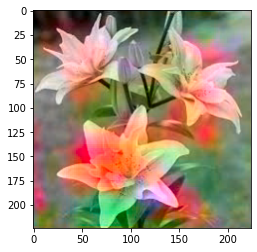

In [46]:
colorize("/content/drive/MyDrive/Image colorizer/Images_flowers/Lilies/lily flower25.jpg")

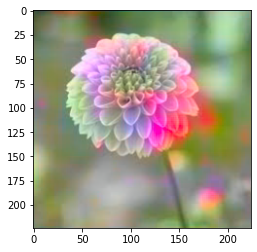

In [43]:
colorize("/content/drive/MyDrive/Image colorizer/Images_flowers/Dahlias/Dahlia flowers10.jpg")

In [ ]:
# Need to train more for better results